In [1]:
from main import *
from sklearn import clone

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.935, total=  13.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


[CV] .................................... , score=0.937, total=  10.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s


[CV] .................................... , score=0.937, total=  12.2s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=  11.3s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=  10.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.937, total=  13.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV] .................................... , score=0.938, total=  14.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.6s remaining:    0.0s


[CV] .................................... , score=0.939, total=  13.4s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  13.4s
[CV]  ................................................................
[CV] .................................... , score=0.939, total=  13.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.937, total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] .................................... , score=0.936, total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.2s remaining:    0.0s


[CV] .................................... , score=0.936, total=  10.0s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=   9.6s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=   9.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.938, total=  12.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV] .................................... , score=0.939, total=  13.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.1s remaining:    0.0s


[CV] .................................... , score=0.938, total=  11.5s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  11.7s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  11.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.8s finished


<AxesSubplot:>

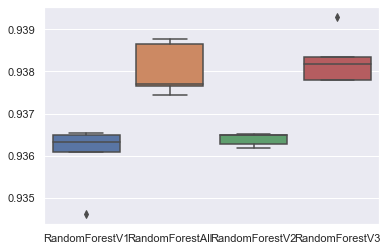

In [2]:
clf = RandomForestClassifier(n_jobs=-1)
models = {
    "RandomForestV1": [clone(clf), ["car_ownership", "house_ownership", "married", "profession", "city", "state"]],
    "RandomForestAll": [clone(clf), []],
    "RandomForestV2": [clone(clf), ["profession", "city", "state"]],
    "RandomForestV3": [clone(clf), ["car_ownership", "house_ownership", "married"]]
}

res = pd.DataFrame.from_dict(
        {model_name: eval_model(model, data_preprocess(drop_cols, [])[0]) for model_name, (model, drop_cols) in models.items()}    
    )
sns.boxplot(data=res)

## Note: can safely remove `["car_ownership", "house_ownership", "married"]`

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.938, total=  12.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] .................................... , score=0.940, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV] .................................... , score=0.938, total=   8.6s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=   8.6s
[CV]  ................................................................
[CV] .................................... , score=0.939, total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   48.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.937, total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV] .................................... , score=0.937, total=  15.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.7s remaining:    0.0s


[CV] .................................... , score=0.939, total=  16.6s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  16.9s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  16.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.937, total=  25.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] .................................... , score=0.939, total=  23.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.6s remaining:    0.0s


[CV] .................................... , score=0.937, total=  25.1s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  26.2s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=  24.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.937, total=  33.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s remaining:    0.0s


[CV] .................................... , score=0.939, total=  32.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.938, total=  32.1s
[CV]  ................................................................
[CV] .................................... , score=0.937, total=  33.3s
[CV]  ................................................................
[CV] .................................... , score=0.937, total=  35.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


<AxesSubplot:>

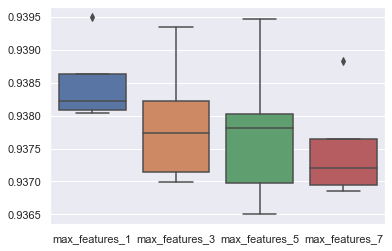

In [19]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, [transformfn1])[0]

param = "max_features"
par_vals = [i+1 for i in range(0, df_train.shape[1]-1, 2)]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(RandomForestClassifier(n_jobs=-1, **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

## Note: a smaller `max_features` value seems better

In [ ]:
from sklearn.ensemble import StackingClassifie